In [4]:
'''
Focuses on app_train only
'''

In [1]:
# imports
from utils import *
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)
ONE HOT ENCODED
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
ALIGNED:
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)
There were 9274 anomalies in the test data out of 48744 entries
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 240)
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 231)


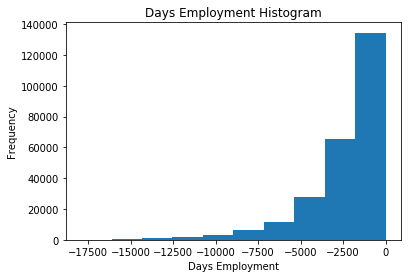

In [2]:
# do basic pre-processing
def pre_process():
    # read data
    train_data = load_training_data()
    test_data = load_test_data()
    train_data, test_data = encode_binary_cols(train_data, test_data)
    train_data, test_data = one_hot_encode(train_data, test_data)
    train_data, test_data, train_Y = align_data(train_data, test_data)
    train_data, test_data = remove_days_employed_anomaly(train_data, test_data)
    train_data, test_data = remove_missing_cols(train_data, test_data)
    return train_data, test_data

train_data, test_data = pre_process()

In [3]:
def mean_impute(df):
    return df.fillna(df.mean())

train_data = mean_impute(train_data)
test_data = mean_impute(test_data)

In [4]:
def normalise(train, test):
    # MAKE SURE SK_CURR_ID AND TARGET have been dropped
    # Normalise
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale each feature to 0-1
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    print("NORMALISED:")
    print('Training data shape: ', train.shape)
    print('Testing data shape: ', test.shape)
    return train, test

In [55]:
def gbm_basic(train_X:np.array, train_Y, test_X, feature_names, model_save_path, n_folds=5):
    print('Training Data Shape: ', train_X.shape)
    print('Testing Data Shape: ', test_X.shape)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_X.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(train_X.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
     # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(train_X):
        
        # Training data for the fold
        train_features, train_labels = train_X[train_indices], train_Y[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = train_X[valid_indices], train_Y[valid_indices]
        
         # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances - get the average from all the splits in a fold
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions - get the average from all the folds
        test_predictions += model.predict_proba(test_X, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions 
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Save model - will keep overwriting so saves last model in the end
        save_pickle(model_save_path, model)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
            
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(train_Y, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return test_predictions, feature_importances, metrics

In [65]:
# gbm run for features
train_X, test_X , train_Y= align_data(train_data, test_data)
train_X = train_X.drop(columns=['TARGET'])
train_X = train_X.drop(columns=['SK_ID_CURR'])
test_X = test_X.drop(columns=['SK_ID_CURR'])
print('Training Data Shape: ', train_X.shape); print('Testing Data Shape: ', test_X.shape)
feature_names = train_X.columns
train_X, test_X = normalise(train_X, test_X)

# test_Y, feature_importances, score_metrics = gbm_basic(train_X, train_Y, test_X, feature_names, 
#                                                        model_save_path="../models/gbm_features_basic.pickle" ,n_folds=5)
# create_and_save_submission(test_imputed, test_Y, save_path='../test_predictions/gbm_features_basic.csv')
# save_pickle("../misc/gbm_simple_feature_importances.pickle", feature_importances)

ALIGNED:
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 231)
Training Data Shape:  (307511, 230)
Testing Data Shape:  (48744, 230)


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


NORMALISED:
Training data shape:  (307511, 230)
Testing data shape:  (48744, 230)


In [5]:
# TODO LOOK AT GBM CODE - SAVING BEST MODEL

def get_top_gbm_features(path, num_feats):
    # get the names of the top n features for gbm 
    gbm_fi = load_pickle(path)
    top_feats =  gbm_fi.sort_values(by=["importance"], ascending=False)[:num_feats]['feature'].values
    return top_feats
    
top_gbm_feats = get_top_gbm_features("../misc/gbm_simple_feature_importances.pickle", 30)
print(top_gbm_feats)

['EXT_SOURCE_1' 'EXT_SOURCE_3' 'EXT_SOURCE_2' 'DAYS_BIRTH' 'AMT_CREDIT'
 'AMT_ANNUITY' 'DAYS_EMPLOYED' 'DAYS_ID_PUBLISH' 'AMT_GOODS_PRICE'
 'DAYS_LAST_PHONE_CHANGE' 'DAYS_REGISTRATION' 'REGION_POPULATION_RELATIVE'
 'AMT_INCOME_TOTAL' 'OWN_CAR_AGE' 'HOUR_APPR_PROCESS_START'
 'TOTALAREA_MODE' 'AMT_REQ_CREDIT_BUREAU_YEAR' 'BASEMENTAREA_MODE'
 'APARTMENTS_MODE' 'NAME_CONTRACT_TYPE' 'AMT_REQ_CREDIT_BUREAU_QRT'
 'LANDAREA_MODE' 'YEARS_BEGINEXPLUATATION_MODE'
 'NAME_EDUCATION_TYPE_Higher education' 'APARTMENTS_AVG' 'CODE_GENDER_F'
 'BASEMENTAREA_AVG' 'NONLIVINGAREA_AVG' 'LIVINGAREA_MODE'
 'OBS_30_CNT_SOCIAL_CIRCLE']


In [6]:
def get_sorted_correlations(df, feature,):
    correlations = df.corr()[feature]
    correlations = abs(correlations).sort_values(ascending=False)  # sort by correlation value (regardless if it's positive or negative)
    correlations = correlations.dropna()  # drop nans
    if 'TARGET' in correlations:
        correlations = correlations.drop(labels=[feature, 'TARGET'])  # remove corr to itself and target
    return correlations

def get_top_correlations(corrs, num_feats):
    return corrs[:num_feats].keys()


# pcc_corrs = get_sorted_correlations(train_data, 'TARGET')
# save_pickle('../misc/target_corr_sorted_pcc.pickle', pcc_corrs)
pcc_corrs = load_pickle('../misc/target_corr_sorted_pcc.pickle')
# print(pcc_corrs)

# pcc_corrs = load_pickle('../misc/target_corr_sorted_pcc.pickle')
pcc_corrs = get_top_correlations(pcc_corrs, 30)
print(pcc_corrs)


Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 'CODE_GENDER_F',
       'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA',
       'DAYS_EMPLOYED_ANOM', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'FLAG_DOCUMENT_3', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
       'OCCUPATION_TYPE_Laborers', 'EMERGENCYSTATE_MODE_No',
       'DAYS_REGISTRATION', 'HOUSETYPE_MODE_block of flats', 'AMT_GOODS_PRICE',
       'OWN_CAR_AGE'],
      dtype='object')


In [7]:
# get the top features agreed on by both pearsons correlation and lgbm
top_corr_feats = set(top_gbm_feats).intersection(set(pcc_corrs))
top_corr_feats = list(top_corr_feats)
len(top_corr_feats)

12

In [9]:
from sklearn.preprocessing import PolynomialFeatures

def create_poly_feats(df, poly_cols, degree):
    # cols to create poly feature from
    selected_cols = df[poly_cols]
    # create polynomial features  to the given degree
    poly_transformer = PolynomialFeatures(degree=degree)
    poly_transformer.fit(selected_cols)
    poly_feats = poly_transformer.transform(selected_cols)
    
    # get the column names of the polynomial features
    col_names = poly_transformer.get_feature_names(poly_cols)
    poly_feats_df = pd.DataFrame(poly_feats, columns=col_names)
    poly_feats_df= poly_feats_df.drop(columns=['1']) #drop the constant column
    return poly_feats_df

def calc_poly_aic_score(feats_df, n=10):
    aic_scores = []
    # calculate the aic score for each of the poly features
    for col in feats_df:
        aic_scores.append(imputed_col_aic(feats_df, col))
    
    aic_df = pd.DataFrame({'col':feats_df.columns, 'aic':aic_scores}) 
    best_n_cols = get_top_aic_cols(aic_df, n)
    return aic_df, best_n_cols 

def get_top_aic_cols(df, n=10):
    # return the n features with the lowest aic score
    return df.sort_values(by='aic')[:n]['col'].values

# get the polynomial features for the training data
train_poly_df = create_poly_feats(train_data, top_corr_feats, 2)
train_poly_df['TARGET'] = train_data['TARGET'] # add Target col to train

# get the polynomial features for the testing
test_poly_df = create_poly_feats(test_data, top_corr_feats, 2)

# get the aic scores for each poly feature and the best features 
poly_aic_df, lowest_aic_cols = calc_poly_aic_score(train_poly_df, n=20)


Optimization terminated successfully.
         Current function value: 0.280846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.282745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.279522
  

Optimization terminated successfully.
         Current function value: 0.329591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455509
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.439002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.541346
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.449322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403788
         Iterations 7
         Current function value: 0.637190
         Iterations: 35


C:\Users\Bhumika\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
def merge_poly_feats(train_df, test_df, poly_train, poly_test):
    # pass in original train and test dataframes and the dataframes for the poly features
    
    # Merge polynomial features into training dataframe
    print(train_df.shape, test_df.shape)
    poly_train['SK_ID_CURR'] = train_df['SK_ID_CURR']
    poly_train = train_data.merge(poly_train, on = 'SK_ID_CURR', how = 'left')

    #  Merge polynomial features into testing dataframe
    poly_test['SK_ID_CURR'] = test_df['SK_ID_CURR']
    poly_test = test_data.merge(poly_test, on = 'SK_ID_CURR', how = 'left')

    print(poly_train.shape, poly_test.shape)
    return poly_train, poly_test

train_poly = train_poly_df[lowest_aic_cols] #top poly feature df
test_poly = test_poly_df[lowest_aic_cols] #top poly feature df

train_poly, test_poly = merge_poly_feats(train_data, test_data, train_poly, test_poly)

# 'TARGET' should be the only extra feature in train_poly
print(set(train_poly.columns).difference(set(test_poly.columns)))


(307511, 232) (48744, 231)
(307511, 252) (48744, 251)
{'TARGET'}


In [56]:
# run gbm with the added poly feature this time

# gbm run for features
train_X, test_X , train_Y= align_data(train_poly, test_poly)
train_X = train_X.drop(columns=['TARGET'])
train_X = train_X.drop(columns=['SK_ID_CURR'])
test_X = test_X.drop(columns=['SK_ID_CURR'])
print('Training Data Shape: ', train_X.shape); print('Testing Data Shape: ', test_X.shape)
feature_names = train_X.columns
train_X, test_X = normalise(train_X, test_X)

# test_Y, feature_importances, score_metrics = gbm_basic(train_X, train_Y, test_X, feature_names, 
#                                                        model_save_path="../models/lgbm_poly_feats.pickle" ,n_folds=5)

# print(score_metrics)
# create_and_save_submission(test_imputed, test_Y, save_path='../test_predictions/lgbm_poly_feats.csv')


ALIGNED:
Training Features shape:  (307511, 252)
Testing Features shape:  (48744, 251)
Training Data Shape:  (307511, 250)
Testing Data Shape:  (48744, 250)


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


NORMALISED:
Training data shape:  (307511, 250)
Testing data shape:  (48744, 250)
Training Data Shape:  (307511, 250)
Testing Data Shape:  (48744, 250)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.75423	valid's binary_logloss: 0.562766	train's auc: 0.79965	train's binary_logloss: 0.552252
Early stopping, best iteration is:
[249]	valid's auc: 0.754458	valid's binary_logloss: 0.557706	train's auc: 0.808133	train's binary_logloss: 0.544999
File saved at  ../models/lgbm_poly_feats.pickle
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.757827	valid's binary_logloss: 0.563112	train's auc: 0.799626	train's binary_logloss: 0.552356
Early stopping, best iteration is:
[241]	valid's auc: 0.758206	valid's binary_logloss: 0.558844	train's auc: 0.806536	train's binary_logloss: 0.546298
File saved at  ../models/lgbm_poly_feats.pickle
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.763184	val

In [12]:
# train_poly = mean_impute(train_poly)
# test_poly = mean_impute(test_poly)
train_X, test_X , train_Y= align_data(train_poly, test_poly)
train_X = train_X.drop(columns=['TARGET'])
train_X = train_X.drop(columns=['SK_ID_CURR'])
test_X = test_X.drop(columns=['SK_ID_CURR'])
print('Training Data Shape: ', train_X.shape); print('Testing Data Shape: ', test_X.shape)
feature_names = train_X.columns
train_X, test_X = normalise(train_X, test_X)


ALIGNED:
Training Features shape:  (307511, 252)
Testing Features shape:  (48744, 251)
Training Data Shape:  (307511, 250)
Testing Data Shape:  (48744, 250)


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


NORMALISED:
Training data shape:  (307511, 250)
Testing data shape:  (48744, 250)


In [74]:
def cross_val_roc_curve(train_X, train_Y, classifier):
    # From https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

    # ROC AUC with stratified cross validation
    X = train_X
    y = train_Y

    cv = StratifiedKFold(n_splits=6, shuffle=True)
    tprs = []  # true positive rate scores
    aucs = []  # area under curve scores
    mean_fpr = np.linspace(0, 1, 100)  # mean false positive rates

    i = 0
    # train and test for each fold
    for train_sample, test_sample in cv.split(X, y):
        probas_ = classifier.fit(X[train_sample], y[train_sample]).predict_proba(X[test_sample])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test_sample], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        print("Run {} AUC socre: {}".format(i, roc_auc))

        '''Everything below this point is just for the plot'''
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    # plot roc curve for fold
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    # caluclate and plot mean auc
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # plot standard deviation area
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # add labels to plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    print("Avg ROC AUC score: {}".format(np.mean(aucs)))

model = load_pickle("../models/log_reg_opt.pickle")
# train_X, test_X, feature_names = normalise_and_impute(train_data, test_data, impute_strategy='mean')
cross_val_roc_curve(train_X, train_Y, model)

ALIGNED:
Training Features shape:  (307511, 252)
Testing Features shape:  (48744, 251)
Training Data Shape:  (307511, 250)
Testing Data Shape:  (48744, 250)


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


NORMALISED:
Training data shape:  (307511, 250)
Testing data shape:  (48744, 250)
File saved at  ../models/log_reg_baseline_poly_feats.pickle
Log reg baseline model saved to:  ../models/log_reg_baseline_poly_feats.pickle
Predictions saved to:  ../test_predictions/test.csv


In [16]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

def random_search_log_reg(train, train_Y, test, save_path):
    '''
    Mean imputation
    Best C:  1.668088018810296
    test acc -> 0.74041
    '''
    model = LogisticRegression()

    # Search parameters and search space
    C = uniform(loc=0, scale=4)
    hyperparameters = dict(C=C,)

    # Create randomized search 5-fold cross validation and 100 iterations
    clf = RandomizedSearchCV(model, hyperparameters, random_state=1, n_iter=10, cv=3, verbose=3, n_jobs=10) # will take a while to run
    # Fit randomized search
    best_model = clf.fit(train, train_Y)

    print('Best C:', best_model.best_estimator_.get_params()['C'])

    predictions = best_model.predict_proba(test)[:, 1]

    # Save model
    save_pickle(save_path, best_model)  # save model
    print("Log reg baseline model saved to: ", save_path)

    return model, predictions

model, preds = random_search_log_reg(train_X, train_Y, test_X, save_path="../models/log_reg_tuned_poly_feats.pickle")
create_and_save_submission(test_data, preds, save_path='../test_predictions/log_reg_tuned_poly_feats.csv')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 out of  30 | elapsed:  3.9min remaining:  1.4min
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:  4.9min finished


Best C: 1.668088018810296
File saved at  ../models/log_reg_tuned_poly_feats.pickle
Log reg baseline model saved to:  ../models/log_reg_tuned_poly_feats.pickle
Predictions saved to:  ../test_predictions/log_reg_tuned_poly_feats.csv
